In [207]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)



def plot_embed_with_label(dfp, label_col = ['cancer_type'],  label_type = ['c'], orders = [None], colors = [None],
                          figsize=(10,10), metric='correlation',  
                          n_neighbors=10, min_dist = 0.8, spread = 1, s = 4, random_state = 456,
                           verbose = False, return_coord = True,
                          cmap = 'bright', **kwargs):


    '''
    dfp: dataframe of samples x genes, with a column contains batch information
    label_col: list of labels to be used
    label_type: list of the label types, 'c' for categorical label, 'r' for continous label
    ''' 

    glist = dfp.columns[~dfp.columns.isin(label_col)]
    if len(glist) == 2:
        df2d = dfp[glist]
    else:
        mp = UMAP(spread=spread, min_dist=min_dist, n_neighbors=n_neighbors, 
                  metric=metric, random_state=random_state,
                  verbose=verbose,  **kwargs) #, metric='correlation'
        embed = mp.fit_transform(dfp[glist])
        df2d = pd.DataFrame(embed, columns=['UMAP1', 'UMAP2'],index=dfp.index)
    col1, col2 = df2d.columns
    df2d = df2d.join(dfp[label_col])
    
    figs = []
    for label, t, order, color in zip(label_col, label_type, orders, colors):
        fig, ax = plt.subplots(figsize=figsize) 
        if t == 'c': 
            cohort_order =  order #df2d.groupby(label).size().sort_values().index
            if cohort_order is None:
                cohort_order = df2d.groupby(label).size().sort_values().index

            if color is None:
                if type(cmap) == dict:
                    color = pd.Series(cmap).loc[cohort_order].values
                else:
                    color =  sns.color_palette(cmap, len(cohort_order)).as_hex()

            print(color, cohort_order)
            
            for bt, c in zip(cohort_order, color):
                dfp1 = df2d[df2d[label] == bt]
                ax.scatter(dfp1[col1], dfp1[col2], label = bt, s = s,  c = c)
                
                #print(color)
            if len(cohort_order) <= 10:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(loc='center left', ncol=1, prop={'size':12},  bbox_to_anchor=(1, 0.5)) #
        else:
            ax.scatter(df2d[col1], df2d[col2], label = label, s = s, c = df2d[label], cmap = cmap)        
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
        ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
        sns.despine(top=True, right=True, left=False, bottom=False)
        ax.set_xlabel(col1)
        ax.set_ylabel(col2)
        ax.set_title(label)
        
        figs.append(fig)
    if not return_coord:
        return figs
    else:
        return figs, df2d

In [208]:
# load the pretrained model as a feature extractor
pretrainer = loadconceptor('../../checkpoint/latest/pretrainer.pt')
#pretrainer = loadconceptor('../checkpoint/notask/bc_pretrainer.pt')

genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

1019421

In [209]:
sns.color_palette("tab20")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [210]:
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [211]:
import colorbm as cbm
cancer_order = ['GBM',  'LUAD', 'LUSC', 'SKCM', 'BLCA', 'STAD','KIRC' ]
cancer_color = cbm.palettes.ucscgb #sns.color_palette("bright")
cancer_map = dict(zip(cancer_order, cancer_color))

In [212]:
type(cancer_map)

dict

Before and After pretraining

In [213]:
cancer2plot = ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']

In [214]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672/data'
df_label = pd.read_pickle(os.path.join(data_path, 'TCGA.PATIENT.PROCESSED.TABLE'))
df_label.cancer_type = df_label.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
df_tpm = pd.read_pickle(os.path.join(data_path, 'TCGA.TPM.TABLE'))

df_label = df_label[df_label.cancer_type.isin(cancer2plot)]
df_tpm = df_tpm.loc[df_label.index]

dfp1 = df_tpm.join(df_label.cancer_type)
dfcx1 = df_label[['cancer_type']].join(df_tpm)
dfcx1.cancer_type = dfcx1.cancer_type.map(CANCER_CODE)


In [215]:
itrp_data_path = '../../00_data/'

itrp_df_label = pd.read_pickle(os.path.join(itrp_data_path, 'ITRP.PATIENT.TABLE'))
itrp_df_tpm = pd.read_pickle(os.path.join(itrp_data_path, 'ITRP.TPM.TABLE'))
itrp_df_tpm = itrp_df_tpm[pretrainer.feature_name]

itrp_df_label.cohort = itrp_df_label.cancer_type +'_' + itrp_df_label.cohort.apply(lambda x:x.split('_')[0])
dfp2 = itrp_df_tpm.join(itrp_df_label.cancer_type)
dfcx2 = itrp_df_label[['cancer_type']].join(itrp_df_tpm)
dfcx2.cancer_type = dfcx2.cancer_type.map(CANCER_CODE)

len(dfcx1), len(dfcx2)

(2935, 1133)

In [216]:
itrp_df_label.cancer_type.value_counts()

cancer_type
BLCA    408
SKCM    330
KIRC    198
LUAD    102
STAD     45
GBM      25
LUSC     25
Name: count, dtype: int64

### TCGA-ITRP-UMAP before pretraining

In [217]:
dfx = df_tpm._append(itrp_df_tpm)
mp_org = UMAP(metric='correlation',  n_neighbors=20, min_dist = 0.5, spread=1, random_state = 1,verbose = False,)
mp_org = mp_org.fit(dfx.iloc[:len(df_tpm)])

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [218]:
df2d_org = mp_org.transform(dfx)

In [219]:
df2d_org = pd.DataFrame(df2d_org, index = dfc.index, columns = ['UMAP1', 'UMAP2'])

df1_org = df2d_org.iloc[:len(df_tpm)]
df2_org = df2d_org.iloc[-len(itrp_df_tpm):]

df1_org['group'] = 'TCGA'
df1_org = df1_org.join(df_label.cancer_type)

df2_org['group'] = 'ITRP'
df2_org = df2_org.join(itrp_df_label.cancer_type)

/tmp/ipykernel_26038/3604019127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_org['group'] = 'TCGA'
/tmp/ipykernel_26038/3604019127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_org['group'] = 'ITRP'


['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


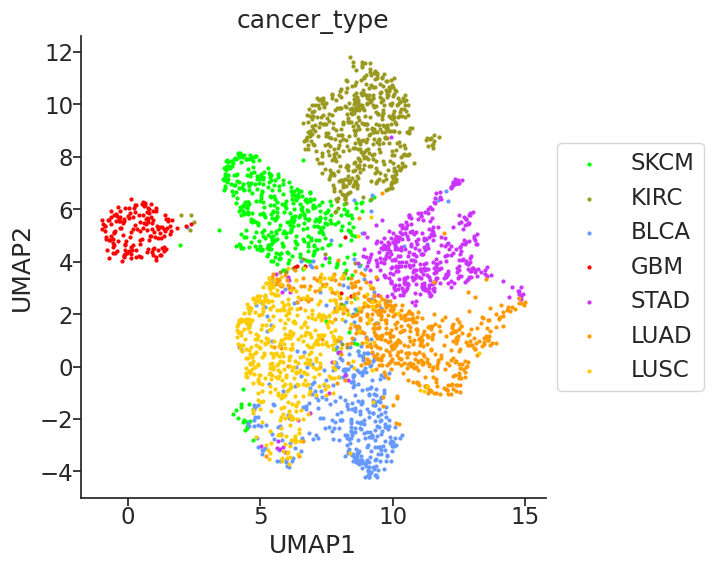

In [220]:
figs1 = plot_embed_with_label(df1_org,label_col=['cancer_type', 'group'],label_type=['c', 'c'], 
                              orders = [cancer2plot], figsize=(6, 6), cmap = cancer_map, verbose=False)

In [221]:
fig = figs1[0][0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('tcga_before_pt.svg',bbox_inches ='tight' )

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


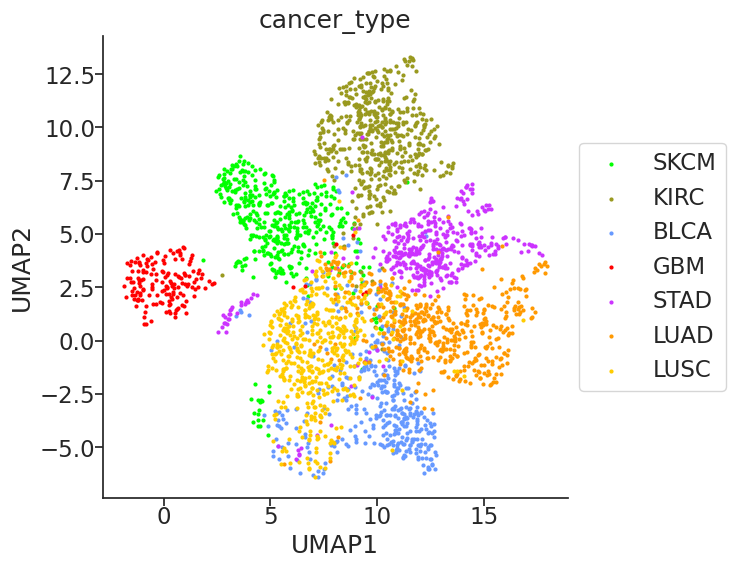

In [222]:
dfp = df_tpm.join(df_label.cancer_type)
figs = plot_embed_with_label(dfp,label_col=['cancer_type'], label_type=['c'], cmap = cancer_map,
                             orders = [cancer2plot], figsize=(6, 6),verbose=False)
fig, df2d = figs
#fig[0].savefig('cancer_tcga_before_pretrain.pdf',bbox_inches ='tight' )

In [223]:
fig = fig[0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('tcga_before_pt.svg',bbox_inches ='tight' )

['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


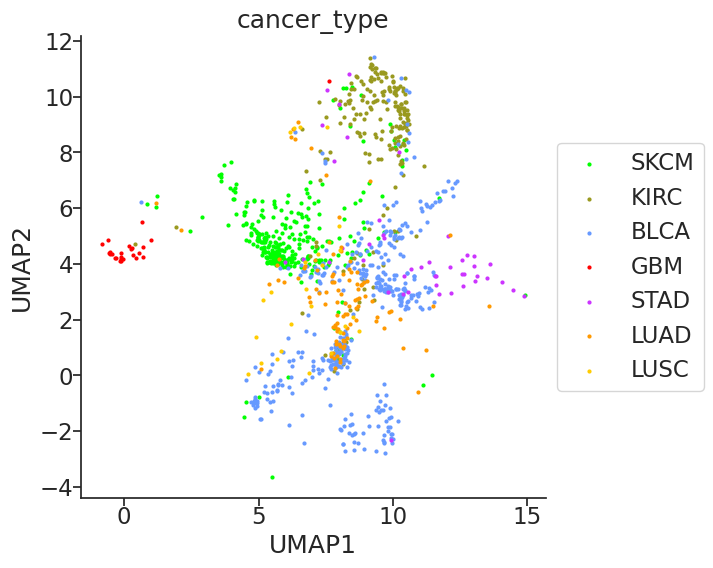

In [224]:
figs1 = plot_embed_with_label(df2_org,label_col=['cancer_type', 'group'],label_type=['c', 'c'], 
                              orders = [cancer2plot], figsize=(6, 6), cmap= cancer_map, verbose=False)

['#d3d3d3', '#00FF00', '#99991E', '#6699FF', '#FF0000', '#CC33FF', '#FF9900', '#FFCC00'] ['TCGA', 'SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']
['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1'] Index(['GBM', 'STAD', 'LUSC', 'LUAD', 'KIRC', 'SKCM', 'BLCA'], dtype='object', name='cancer_type')


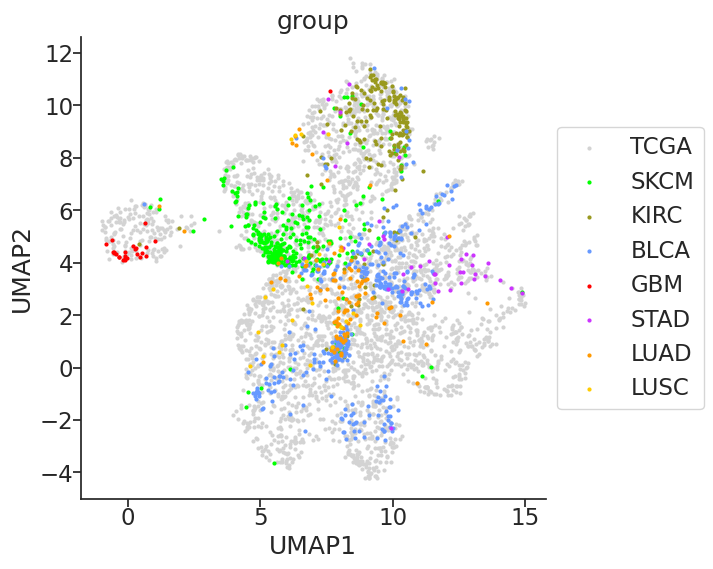

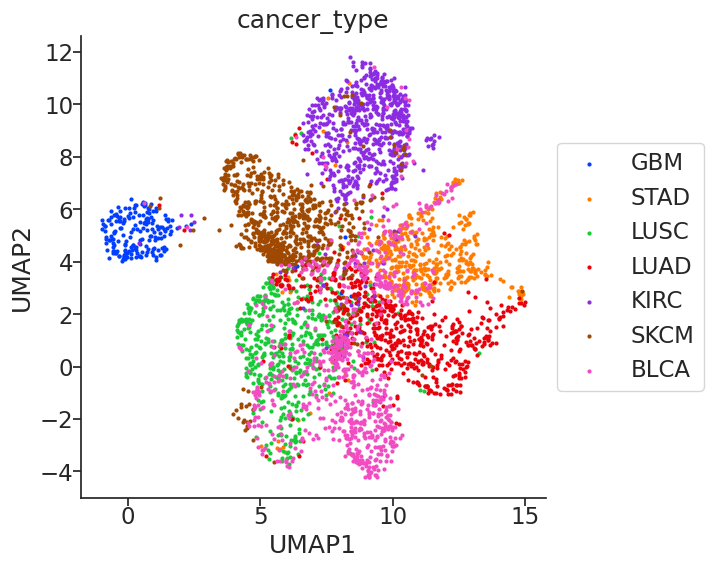

In [225]:
df_org = df1_org._append(df2_org)
cancer_map.update({'TCGA':'#d3d3d3'})
cancer2plot2 = ['TCGA'] + cancer2plot
colors = pd.Series(cancer_map).loc[cancer2plot2].tolist()
df_org.loc[df_org.group == 'ITRP', 'group'] = df_org.loc[df_org.group == 'ITRP', 'cancer_type']

figs1 = plot_embed_with_label(df_org,label_col=['group', 'cancer_type'],label_type=['c', 'c'], 
                              colors = [colors, None],
                              orders = [cancer2plot2, None], figsize=(6, 6), verbose=False)

### TCGA-ITRP-UMAP after pretraining

In [226]:
dfcx = dfcx1._append(dfcx2)
dfg, dfc = pretrainer.extract(dfcx, batch_size=64)
mp = UMAP(metric='correlation',  n_neighbors=20,  min_dist = 0.8, spread=1, random_state = 1,verbose = False,)
mp = mp.fit(dfc.iloc[:len(dfcx1)]) #
df2d = mp.transform(dfc)

100%|##########| 64/64 [00:04<00:00, 14.44it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [227]:
df2d = pd.DataFrame(df2d, index = dfc.index, columns = ['UMAP1', 'UMAP2'])

In [228]:
df1 = df2d.iloc[:len(dfcx1)]
df2 = df2d.iloc[-len(dfcx2):]

df1['group'] = 'TCGA'
df1 = df1.join(dfp1.cancer_type)

df2['group'] = 'ITRP'
df2 = df2.join(dfp2.cancer_type)

/tmp/ipykernel_26038/3769673793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['group'] = 'TCGA'
/tmp/ipykernel_26038/3769673793.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['group'] = 'ITRP'


['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


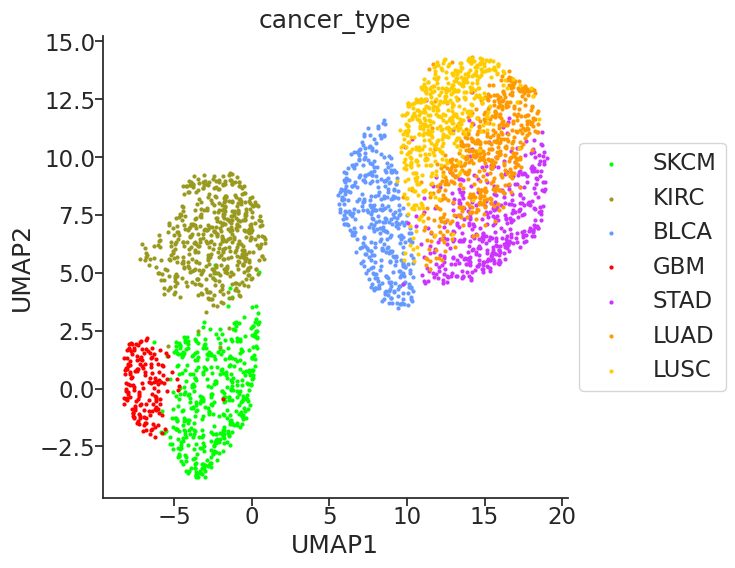

In [229]:
figs1 = plot_embed_with_label(df1, label_col=['cancer_type', 'group'],label_type=['c', 'c'], 
                              orders = [cancer2plot], figsize=(6, 6), cmap= cancer_map, verbose=False)

In [230]:
fig = figs1[0][0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('tcga_after_pt.svg',bbox_inches ='tight' )

['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


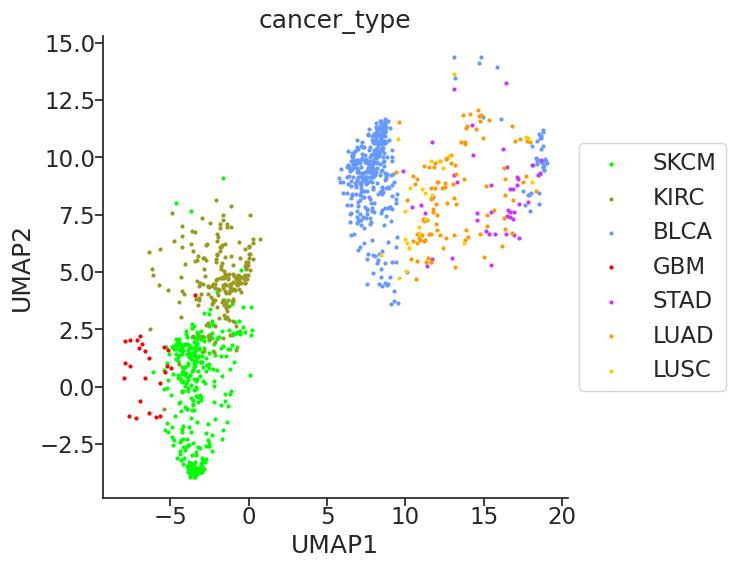

In [231]:
figs1 = plot_embed_with_label(df2,label_col=['cancer_type', 'group'],label_type=['c', 'c'], 
                              orders = [cancer2plot], figsize=(6, 6), cmap= cancer_map, verbose=False)


['#d3d3d3', '#00FF00', '#99991E', '#6699FF', '#FF0000', '#CC33FF', '#FF9900', '#FFCC00'] ['TCGA', 'SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']
['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1'] Index(['GBM', 'STAD', 'LUSC', 'LUAD', 'KIRC', 'SKCM', 'BLCA'], dtype='object', name='cancer_type')


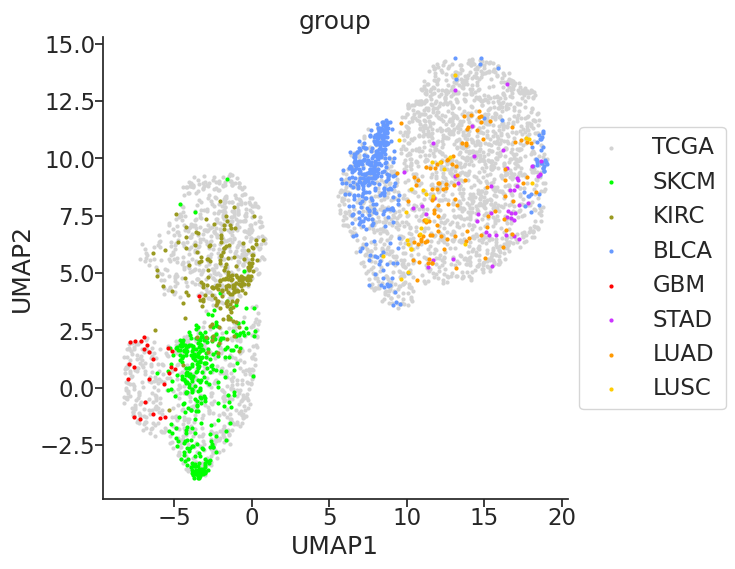

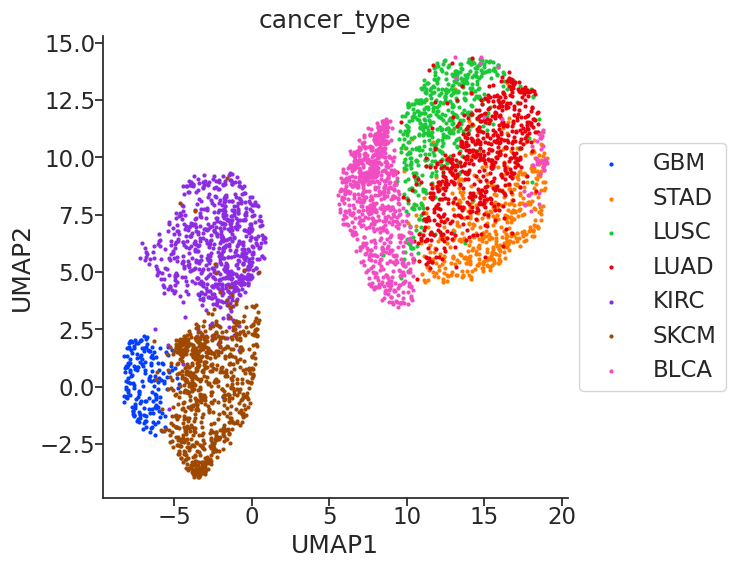

In [232]:
df = df1._append(df2)
cancer_map.update({'TCGA':'#d3d3d3'})
cancer2plot2 = ['TCGA'] + cancer2plot
colors = pd.Series(cancer_map).loc[cancer2plot2].tolist()
df.loc[df.group == 'ITRP', 'group'] = df.loc[df.group == 'ITRP', 'cancer_type']

figs1 = plot_embed_with_label(df,label_col=['group', 'cancer_type'],label_type=['c', 'c'], 
                              colors = [colors, None],
                              orders = [cancer2plot2, None], figsize=(6, 6), verbose=False)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


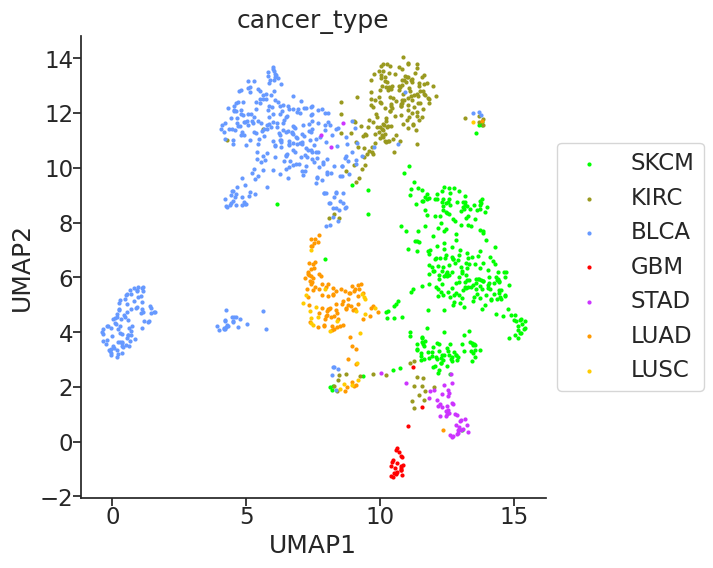

In [244]:
dfp = itrp_df_tpm.join(itrp_df_label.cancer_type)
figs = plot_embed_with_label(dfp,label_col=['cancer_type'],label_type=['c'], cmap = cancer_map,
                             n_neighbors=20, min_dist=0.5, random_state = 1, spread=1,
                             orders = [cancer2plot], figsize=(6, 6), verbose=False)
fig, df2d = figs
fig[0].savefig('cancer_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_itrp_before_pretrain.csv')

In [245]:
fig = fig[0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('itrp_before_pretrain.svg',bbox_inches ='tight' )

100%|##########| 9/9 [00:01<00:00,  6.07it/s]
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


['#00FF00' '#99991E' '#6699FF' '#FF0000' '#CC33FF' '#FF9900' '#FFCC00'] ['SKCM', 'KIRC', 'BLCA', 'GBM', 'STAD', 'LUAD', 'LUSC']


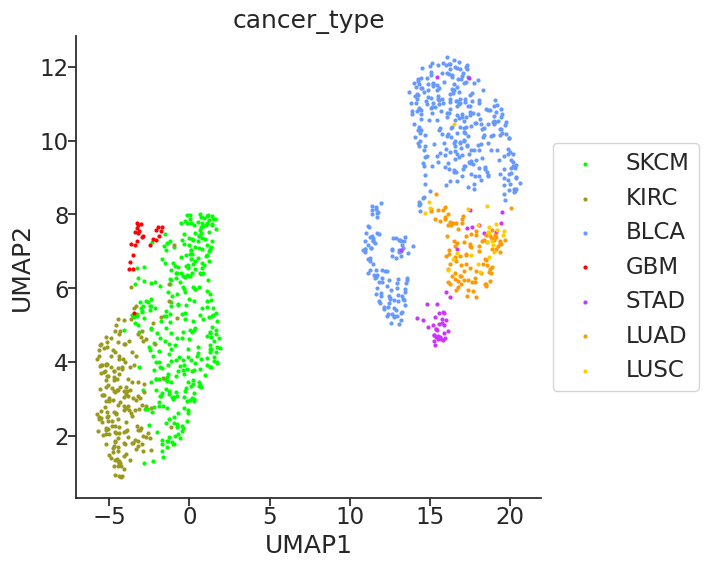

In [237]:
dfcx = itrp_df_label.cancer_type.map(CANCER_CODE).to_frame().join(itrp_df_tpm)
dfg, dfc = pretrainer.extract(dfcx, batch_size=128)
dfp1 = dfc[dfc.columns[:]].join(itrp_df_label.cancer_type)
figs1 = plot_embed_with_label(dfp1,label_col=['cancer_type'],label_type=['c'],cmap = cancer_map, 
                              n_neighbors=20,
                              min_dist=0.5, random_state = 1,
                              spread=1,
                              orders = [cancer2plot], figsize=(6, 6),)
fig1, df2d = figs1
fig1[0].savefig('cancer_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cancer_itrp_after_pretrain.csv')

In [239]:
fig = figs1[0][0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('itrp_after_pretrain.svg',bbox_inches ='tight' )

In [248]:
cohort2plot = [
                
 'SKCM_Hugo',
 'SKCM_Riaz',
 'SKCM_Gide',
 'SKCM_MGH',
 'SKCM_Liu',
 'SKCM_Allen',

'LUSC_SU2CLC2',
 'LUAD_SU2CLC1',

    
'KIRC_IMmotion150',
 'KIRC_Choueiri',
 'KIRC_Miao',
 

 'BLCA_IMVigor210',
 'BLCA_Rose',
 'BLCA_Snyder',
    
 'GBM_Zhao',
 'STAD_Kim']

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


['#d60000', '#8c3bff', '#018700', '#00acc6', '#97ff00', '#ff7ed1', '#6b004f', '#ffa52f', '#573b00', '#005659', '#0000dd', '#00fdcf', '#a17569', '#bcb6ff', '#95b577', '#bf03b8'] ['SKCM_Hugo', 'SKCM_Riaz', 'SKCM_Gide', 'SKCM_MGH', 'SKCM_Liu', 'SKCM_Allen', 'LUSC_SU2CLC2', 'LUAD_SU2CLC1', 'KIRC_IMmotion150', 'KIRC_Choueiri', 'KIRC_Miao', 'BLCA_IMVigor210', 'BLCA_Rose', 'BLCA_Snyder', 'GBM_Zhao', 'STAD_Kim']


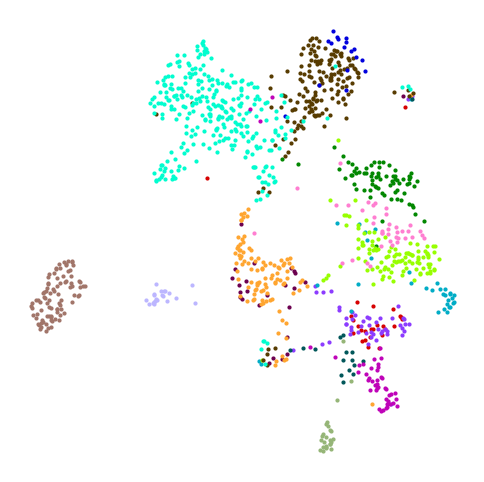

In [253]:
import colorcet as cc
cohort_color = sns.color_palette(cc.glasbey, n_colors= len(cohort2plot))

dfp0 = itrp_df_tpm.join(itrp_df_label.cohort)
figs1 = plot_embed_with_label(dfp0,label_col=['cohort'],label_type=['c'], cmap = cohort_color, n_neighbors=20,
                              min_dist=0.5, random_state = 1, spread=1,
                              orders = [cohort2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cohort_itrp_before_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cohort_itrp_before_pretrain.csv')


fig = fig1[0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('cohort_itrp_before_pretrain.svg',bbox_inches ='tight' )


/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


['#d60000', '#8c3bff', '#018700', '#00acc6', '#97ff00', '#ff7ed1', '#6b004f', '#ffa52f', '#573b00', '#005659', '#0000dd', '#00fdcf', '#a17569', '#bcb6ff', '#95b577', '#bf03b8'] ['SKCM_Hugo', 'SKCM_Riaz', 'SKCM_Gide', 'SKCM_MGH', 'SKCM_Liu', 'SKCM_Allen', 'LUSC_SU2CLC2', 'LUAD_SU2CLC1', 'KIRC_IMmotion150', 'KIRC_Choueiri', 'KIRC_Miao', 'BLCA_IMVigor210', 'BLCA_Rose', 'BLCA_Snyder', 'GBM_Zhao', 'STAD_Kim']


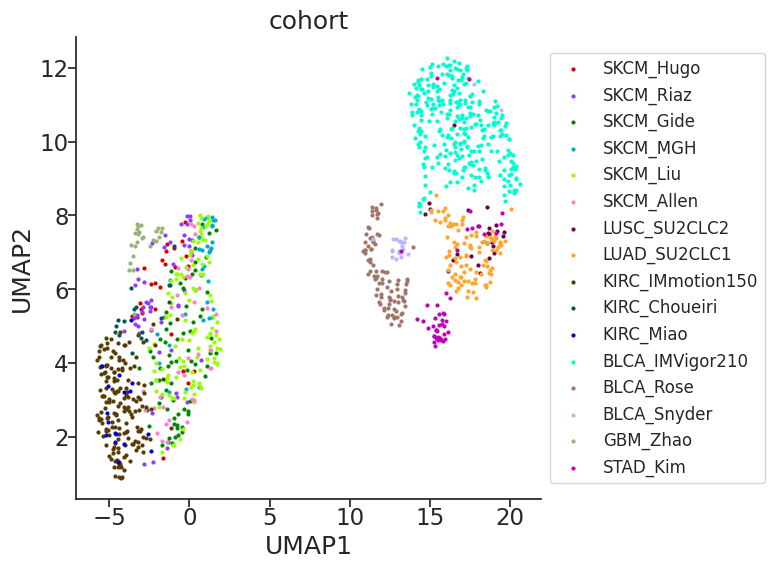

In [251]:
dfp1 = dfc[dfc.columns[:]].join(itrp_df_label.cohort)
figs1 = plot_embed_with_label(dfp1,label_col=['cohort'],label_type=['c'], cmap = cohort_color,n_neighbors=20,
                              min_dist=0.5, random_state = 1, spread=1,
                              orders = [cohort2plot], figsize=(6, 6), verbose=False)
fig1, df2d = figs1
fig1[0].savefig('cohort_itrp_after_pretrain.pdf',bbox_inches ='tight' )
df2d.to_csv('cohort_itrp_after_pretrain.csv')

In [252]:
fig = fig1[0]
axes = fig.get_axes()

# Remove the x and y axis for each axis in the figure
for ax in axes:
    ax.axis('off')
    ax.set_title('')
    ax.get_legend().remove()

fig.savefig('cohort_itrp_after_pretrain.svg',bbox_inches ='tight' )